I wrote this notebook while learning about Variational Bayes & Variational Autoencoders in order to apply them to some agent designs in the MineRL Basalt 2021 Challenge. This implements a VAE in FastAI.jl/FluxML. The VAE in this notebook will then be used as part of a recurrent world model in the MineRL Basalt 2021 Challenge, and thus uses one of the human demonstration videos for training data. To obtain the data used in this notebook, go to [this link](https://minerl.io/dataset/) and follow the instructions for installing minerl in a Python virtual environment (miniconda recommended).

When the library is installed, open [sample-basalt-video-frames.ipynb](sample-basalt-video-frames.ipynb) and run the cells to get some frames of minecraft!

In [47]:
using CUDA
using FastAI
using FastAI: FluxTraining
using MLDataPattern
using Flux
using Flux.Zygote: Params
using Flux.Optimise: update!
using Statistics: mean
using StaticArrays
using Colors
using Images
import CairoMakie; CairoMakie.activate!(type="png")

A Variational Autoencoder is an unsupervised learning method, and as such, has no labels as in the supervised learning setting. We'll create versions of [BlockMethod](https://fluxml.ai/FastAI.jl/dev/docs/learning_methods.md.html) that support our needs, which include the datablock structure, which we appropriately pretty-print, along with infrastructure for plotting samples. Notebook is derived from: https://github.com/darsnack/fastai-vae-demo/blob/main/fastai-vae-nb.ipynb

In [4]:
function Base.show(io::IO, method::BlockMethod{<:FastAI.Block})
    print(io, "BlockMethod(", typeof(method.blocks), " -> ", typeof(method.blocks), ")")
end

In [5]:
function FastAI.BlockMethod(block::FastAI.Block, encodings; outputblock = FastAI.encodedblock(encodings, block))
    return BlockMethod(block, encodings, outputblock)
end

In [6]:
function FastAI.plotsample!(f, method::BlockMethod{<:FastAI.Block}, sample)
    blocks = (method.blocks, method.blocks)
    contexts = FastAI.plotcontext(blocks)
    FastAI.plotsample!(f, contexts, blocks, sample)
end

In [7]:
function FastAI.plotxy!(f, method::BlockMethod{<:FastAI.Block}, x, x̂)
    input, target = decode(
        method.encodings,
        Validation(),
        (method.outputblock, method.outputblock),
        (x, x̂))
    FastAI.plotsample!(f, method, (input, target))
end

In [8]:
FastAI.plotblock!(ax, ::Image{2}, data; kwargs...) = FastAI.plotimage!(ax, clamp01.(data); kwargs...)

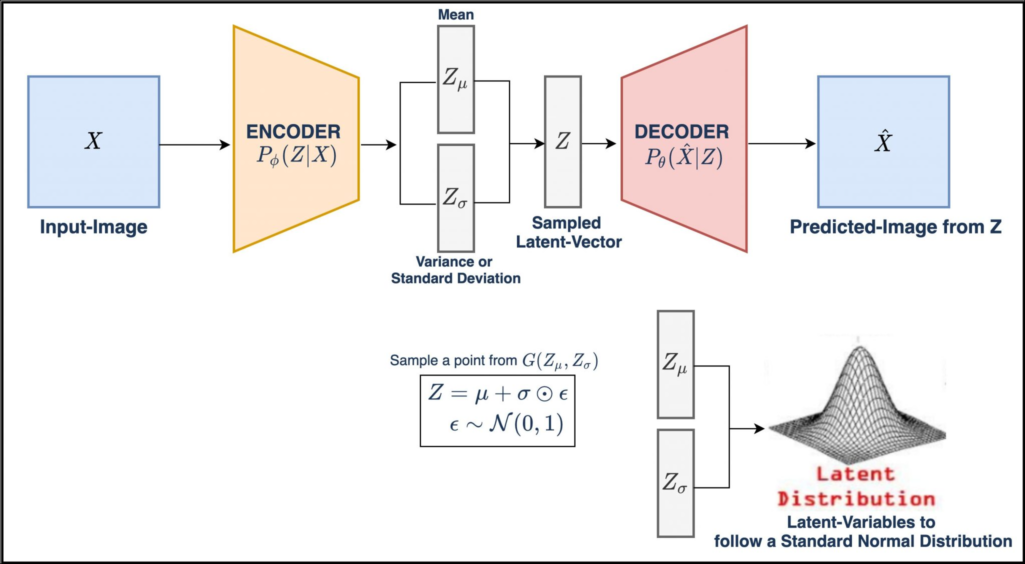

In [8]:
illustration_path = "/home/mu/src/WorldModels.jl/vae-diagram-1-2048x1126.jpg"
load(illustration_path)

In [201]:
# path = datasetpath("images")
data = Datasets.loadfolderdata(
    "images",
    filterfn = isimagefile,
    loadfn = loadfile
)

mapobs(loadfile, ["images/makewaterfall-v0-0.jpg", "images/makewaterfall-v0-1.jpg", "images/makew…])

In [202]:
data

mapobs(loadfile, ["images/makewaterfall-v0-0.jpg", "images/makewaterfall-v0-1.jpg", "images/makew…])

In [203]:
method = BlockMethod(
    Image{2}(),
    ImagePreprocessing(),
)

BlockMethod(Image{2} -> Image{2})

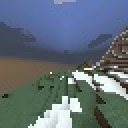

In [204]:
getobs(data, 3)

In [222]:
n_idxs = rand(1:nobs(data), 5)

5-element Vector{Int64}:
 4287
 4397
 3012
 3522
  892

In [223]:
makebatch(method, data, n_idxs)

64×64×3×5 Array{Float32, 4}:
[:, :, 1, 1] =
 -0.405429   -0.439678  -0.439678  …   0.450809    0.759055    0.74193
 -0.508177   -0.456803  -0.542427      0.502183    0.74193     0.776179
 -0.491052   -0.525302  -0.525302      0.724805    0.70768     0.810429
 -1.12467    -0.508177  -0.542427      0.759055    0.793304    0.759055
 -1.02192    -0.645175  -0.525302      0.759055    0.861803    0.793304
 -1.03904    -0.62805   -0.713674  …   0.810429    0.810429    0.861803
 -0.884922   -0.816423  -0.782173      0.74193     0.776179    0.776179
 -0.884922   -0.765048  -0.799298      0.759055    0.656306    0.587807
 -0.456803   -1.24454   -0.799298      0.604932    0.656306    0.810429
 -0.422553   -1.00479   -0.816423      0.604932    0.793304    0.810429
 -0.439678   -1.10754   -0.902046  …   0.861803    0.776179    0.878928
 -0.0629335  -0.936296  -0.98767       0.827554    0.844679    0.861803
 -0.439678   -0.902046  -0.970545      0.793304    0.878928    0.827554
  ⋮                  

In [207]:
size(getobs(data, 3))

(64, 64)

In [145]:
Din = prod(size(getobs(data[1], 1)))

4096

In [ ]:
Conv()

In [224]:
illustration_path = "/home/mu/src/WorldModels.jl/conv-vae-ha-schmidhuber.png"
load(illustration_path)
print("From https://arxiv.org/pdf/1803.10122.pdf")

From https://arxiv.org/pdf/1803.10122.pdf

In [216]:
Dlatent = 64
encoder = Chain(
    Conv((4, 4), 3 => 32, relu; stride=2, pad=1),
    Conv((4, 4), 32 => 64, relu; stride = 2, pad = 1),
    Conv((4, 4), 64 => 128, relu; stride = 2, pad = 1),
    Flux.flatten,
    Dense(64 * 4 * 4, 256, relu), # 512x256
    Dense(256, 256, relu),
    Parallel(
        tuple,
        Dense(256, Dlatent), # μ
        Dense(256, Dlatent), # logσ² (logvar)
    )
) |> gpu

Chain(
  Conv((4, 4), 3 => 32, relu, pad=1, stride=2),  # 1_568 parameters
  Conv((4, 4), 32 => 64, relu, pad=1, stride=2),  # 32_832 parameters
  Conv((4, 4), 64 => 128, relu, pad=1, stride=2),  # 131_200 parameters
  Flux.flatten,
  Dense(1024, 256, relu),               # 262_400 parameters
  Dense(256, 256, relu),                # 65_792 parameters
  Parallel(
    tuple,
    Dense(256, 64),                     # 16_448 parameters
    Dense(256, 64),                     # 16_448 parameters
  ),
)                   # Total: 14 arrays, 526_688 parameters, 1.789 KiB.

In [217]:
32*4*4

512

In [218]:
# define our own Reshape layer 
# (defined in [kastanos20fluxvae] here https://github.com/alecokas/flux-vae/blob/master/conv-vae/main.jl#L14)
struct Reshape
    shape
end

Reshape(args...) = Reshape(args)
(r::Reshape)(x) = reshape(x, r.shape)
Flux.@functor Reshape ()

In [219]:
decoder = Chain(
    Dense(Dlatent, 256, relu),
    Dense(256, 256, relu),
    Dense(256, 32 * 4 * 4, relu), # 256x512
    Reshape(4, 4, 32, :),
    ConvTranspose((4, 4), 32 => 32, relu; stride = 2, pad = 1),
    ConvTranspose((4, 4), 32 => 32, relu; stride = 2, pad = 1),
    ConvTranspose((4, 4), 32 => 3; stride = 2, pad = 1)
) |> gpu

Chain(
  Dense(64, 256, relu),                 # 16_640 parameters
  Dense(256, 256, relu),                # 65_792 parameters
  Dense(256, 512, relu),                # 131_584 parameters
  Reshape((4, 4, 32, Colon())),
  ConvTranspose((4, 4), 32 => 32, relu, pad=1, stride=2),  # 16_416 parameters
  ConvTranspose((4, 4), 32 => 32, relu, pad=1, stride=2),  # 16_416 parameters
  ConvTranspose((4, 4), 32 => 3, pad=1, stride=2),  # 1_539 parameters
)                   # Total: 12 arrays, 248_387 parameters, 1.555 KiB.

Defining the loss function, known as Evidence Lower Bound (ELBO), and a utility to help us sample the latent space.

In [221]:
m1 = Chain(Dense(512, 256, relu), Dense(256, 256, relu))
gpu(m1)(gpu(fs)) |> cpu

LoadError: MethodError: no method matching (::Dense{typeof(relu), CuArray{Float32, 2}, CuArray{Float32, 1}})(::Chain{Tuple{Dense{typeof(relu), CuArray{Float32, 2}, CuArray{Float32, 1}}, Dense{typeof(relu), CuArray{Float32, 2}, CuArray{Float32, 1}}}})
[0mClosest candidates are:
[0m  (::Dense)([91m::AbstractVecOrMat{T} where T[39m) at /home/mu/.julia/packages/Flux/Zz9RI/src/layers/basic.jl:146
[0m  (::Dense)([91m::AbstractArray[39m) at /home/mu/.julia/packages/Flux/Zz9RI/src/layers/basic.jl:151

In [193]:
samples = [getobs(data, i) for i in idxs]
xs = makebatch(method, data, idxs)
ŷs = gpu(encoder)(gpu(xs)) |> cpu

LoadError: DimensionMismatch("A has dimensions (256,512) but B has dimensions (2048,9)")

In [150]:
sample_latent(μ::AbstractArray{T}, logσ²::AbstractArray{T}) where T = 
    μ .+ exp.(logσ² ./ 2) .* randn(T, size(logσ²))

sample_latent (generic function with 2 methods)

In [151]:
sample_latent(μ::CuArray{T}, logσ²::CuArray{T}) where T = 
    μ .+ exp.(logσ² ./ 2) .* gpu(randn(T, size(logσ²)))

sample_latent (generic function with 2 methods)

In [152]:
function βELBO(x, x̄, μ, logσ²; β = 1)
    reconstruction_error = mean(sum(@.((x̄ - x)^2); dims=1))
    # D(N(μ, Σ)||N(0, I)) = 1/2 * (μᵀμ + tr(Σ) - length(μ) - log(|Σ|))
    kl_divergence = mean(sum(@.((μ^2 + exp(logσ²) - 1 - logσ²) / 2); dims = 1))
    return reconstruction_error + β * kl_divergence
end

βELBO (generic function with 1 method)

In [160]:
model = (encoder = encoder, decoder = decoder) |> gpu

(encoder = Chain(Conv((4, 4), 3 => 32, relu, pad=1, stride=2), Conv((4, 4), 32 => 32, relu, pad=1, stride=2), Conv((4, 4), 32 => 32, relu, pad=1, stride=2), flatten, Dense(512, 256, relu), Dense(256, 256, relu), Parallel(tuple, Dense(256, 32), Dense(256, 32))), decoder = Chain(Dense(32, 256, relu), Dense(256, 256, relu), Dense(256, 512, relu), Reshape((4, 4, 32, Colon())), ConvTranspose((4, 4), 32 => 32, relu, pad=1, stride=2), ConvTranspose((4, 4), 32 => 32, relu, pad=1, stride=2), ConvTranspose((4, 4), 32 => 3, pad=1, stride=2)))

In [162]:
using Metalhead
test_enc = Models.xresnet18()

Chain(
  Chain(
    Conv((3, 3), 3 => 32, pad=1, stride=2),  # 896 parameters
    BatchNorm(32, relu),                # 64 parameters, plus 64
  ),
  Chain(
    Conv((3, 3), 32 => 64, pad=1),      # 18_496 parameters
    BatchNorm(64, relu),                # 128 parameters, plus 128
  ),
  Chain(
    Conv((3, 3), 64 => 64, pad=1),      # 36_928 parameters
    BatchNorm(64, relu),                # 128 parameters, plus 128
  ),
  MaxPool((3, 3), pad=1, stride=2),
  Chain(
    ResBlock(
      Chain(
        Chain(
          Conv((3, 3), 64 => 64, pad=1),  # 36_928 parameters
          BatchNorm(64, relu),          # 128 parameters, plus 128
        ),
        Chain(
          Conv((3, 3), 64 => 64, pad=1),  # 36_928 parameters
          BatchNorm(64),                # 128 parameters, plus 128  (all zero)
        ),
      ),
      identity,
      identity,
    ),
    ResBlock(
      Chain(
        Chain(
          Conv((3, 3), 64 => 64, pad=1),  # 36_928 parameters
          BatchNorm(64, 

In [215]:
Flux.outputsize(encoder, (64, 64, 3, 32),)

┌ Error: layer Conv((4, 4), 3 => 32, relu, pad=1, stride=2), index 1 in Chain, gave an error with input of size (64, 64, 3, 32)
└ @ Flux /home/mu/.julia/packages/Flux/Zz9RI/src/outputsize.jl:107


LoadError: GPU compilation of kernel broadcast_kernel(CUDA.CuKernelContext, CuDeviceArray{Flux.NilNumber.Nil, 4, 1}, Base.Broadcast.Broadcasted{Nothing, NTuple{4, Base.OneTo{Int64}}, typeof(relu), Tuple{Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{4}, Nothing, typeof(+), Tuple{Base.Broadcast.Extruded{Array{Flux.NilNumber.Nil, 4}, NTuple{4, Bool}, NTuple{4, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float32, 4, 1}, NTuple{4, Bool}, NTuple{4, Int64}}}}}}, Int64) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{Nothing, NTuple{4, Base.OneTo{Int64}}, typeof(relu), Tuple{Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{4}, Nothing, typeof(+), Tuple{Base.Broadcast.Extruded{Array{Flux.NilNumber.Nil, 4}, NTuple{4, Bool}, NTuple{4, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float32, 4, 1}, NTuple{4, Bool}, NTuple{4, Int64}}}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{4}, Nothing, typeof(+), Tuple{Base.Broadcast.Extruded{Array{Flux.NilNumber.Nil, 4}, NTuple{4, Bool}, NTuple{4, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float32, 4, 1}, NTuple{4, Bool}, NTuple{4, Int64}}}}} which is not isbits.
    .1 is of type Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{4}, Nothing, typeof(+), Tuple{Base.Broadcast.Extruded{Array{Flux.NilNumber.Nil, 4}, NTuple{4, Bool}, NTuple{4, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float32, 4, 1}, NTuple{4, Bool}, NTuple{4, Int64}}}} which is not isbits.
      .args is of type Tuple{Base.Broadcast.Extruded{Array{Flux.NilNumber.Nil, 4}, NTuple{4, Bool}, NTuple{4, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float32, 4, 1}, NTuple{4, Bool}, NTuple{4, Int64}}} which is not isbits.
        .1 is of type Base.Broadcast.Extruded{Array{Flux.NilNumber.Nil, 4}, NTuple{4, Bool}, NTuple{4, Int64}} which is not isbits.
          .x is of type Array{Flux.NilNumber.Nil, 4} which is not isbits.



In [118]:
opt = ADAM(1e-3)
dataiter = DataLoader(batchviewcollated(methoddataset(data[1], method, Training()), 32); buffered = false)
learner = Learner(model, (training = dataiter,), opt, βELBO, ToGPU())
FluxTraining.removecallback!(learner, ProgressPrinter)
;

LoadError: MethodError: no method matching iterate(::FastAI.Datasets.MappedData{typeof(loadfile), SubArray{String, 1, Vector{String}, Tuple{Vector{Int64}}, false}})
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at range.jl:664
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Int64[39m) at range.jl:664
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{var"#s79", var"#s78"} where {var"#s79", var"#s78"<:Dict}, Base.ValueIterator{var"#s77"} where var"#s77"<:Dict} at dict.jl:693
[0m  ...

In [114]:
"""
VAETrainingPhase

Used to implement a custom training loop that takes our ELBO loss into account
"""
struct VAETrainingPhase <: FluxTraining.AbstractTrainingPhase end

VAETrainingPhase

In [115]:
function FluxTraining.step!(learner, phase::VAETrainingPhase, batch)
    FluxTraining.runstep(learner, phase, (x = batch,)) do handle, state
        ps = union(learner.params...)
        x = flatten(dropdims(state.x; dims = ndims(state.x)))
        gs = gradient(ps) do
            # get encode, sample latent, decode
            μ, logσ² = learner.model.encoder(x)
            z = sample_latent(μ, logσ²)
            x̄ = learner.model.decoder(z)
            handle(FluxTraining.LossBegin())
            state.loss = learner.lossfn(x, x̄, μ, logσ²)
            handle(FluxTraining.BackwardBegin())
            return state.loss
        end
        handle(FluxTraining.BackwardEnd())
        update!(learner.optimizer, ps, gs)
    end
end

In [116]:
function FluxTraining.on(::FluxTraining.StepBegin, ::VAETrainingPhase, cb::ToDevice, learner)
    learner.step.x = cb.movedatafn(learner.step.x)
end

### Training the model

In [ ]:
epoch!

In [117]:
for epoch in 1:30
    epoch!(learner, VAETrainingPhase())
end

LoadError: DimensionMismatch("Rank of x and w must match! (2 vs. 4)")

## VQ-VAE
Future plans involve implementing a [Vector-Quantized Variational Autoencoder](http://arxiv.org/abs/1711.00937). This promises to help us create a controllable environment in latent space. This could also be a good demonstration interface for our recurrent world model.